In [ ]:
!pip install TorchCodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.3 MB/s eta 0:00:00


# Audio Scene Classification

This notebook guides you through building and training a simple neural network to classify audio scenes. The task is to identify the environment or setting where an audio recording was captured, such as a 'bus', 'cafe', or 'park', based solely on the sounds present in the audio data. You will implement your own classification network to perform this task.


# Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import random
from IPython.display import Audio, display
from torchsummary import summary
from torch.utils.data import DataLoader
import os
from pathlib import Path
from torch.utils.data import random_split
import importlib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import the Audio Data


In [ ]:
# Download the dataset
zip_file_path = "/home/TCD/Lab-06/dataset.zip"
if not os.path.exists(zip_file_path):
    !curl --create-dirs -o {zip_file_path} https://tcddeeplearning.blob.core.windows.net/deeplearning202324/audiosceneclassification2025.zip
else:
    print(f"File already exists: {zip_file_path}")

# Unzip the dataset if the directory doesn't exist
dataset_dir = "/home/TCD/Lab-06/dataset/"
if not os.path.exists(dataset_dir):
    !unzip /home/TCD/Lab-06/dataset.zip -d {dataset_dir}
else:
    print(f"Dataset directory already exists: {dataset_dir}")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  309M  100  309M    0     0  4706k      0  0:01:07  0:01:07 --:--:-- 4186k
Archive:  /home/TCD/Lab-06/dataset.zip
   creating: /home/TCD/Lab-06/dataset/small_set_complete/
  inflating: /home/TCD/Lab-06/dataset/__MACOSX/._small_set_complete  
  inflating: /home/TCD/Lab-06/dataset/small_set_complete/meta.txt  
  inflating: /home/TCD/Lab-06/dataset/__MACOSX/small_set_complete/._meta.txt  
  inflating: /home/TCD/Lab-06/dataset/small_set_complete/.DS_Store  
  inflating: /home/TCD/Lab-06/dataset/__MACOSX/small_set_complete/._.DS_Store  
   creating: /home/TCD/Lab-06/dataset/small_set_complete/audio/
  inflating: /home/TCD/Lab-06/dataset/__MACOSX/small_set_complete/._audio  
  inflating: /home/TCD/Lab-06/dataset/small_set_complete/audio/b110_110_120.wav  
  inflating: /home/TCD/Lab-06/dataset/__MACOSX/small_set_complete/audio/._b110

# Lets Listen to the Data 👂

The lab is composed of 15 possible scenes. The cell below plays a random clip from the training data and shows its label.

Have a listen with headphones, replay the cell to load another random clip.

In [ ]:
data_root = "/home/TCD/Lab-06/dataset/small_set_complete/"
meta_filename = "meta.txt"
audio_subdir = "audio"

root = Path(data_root).resolve()
audio_dir = root / audio_subdir
meta_path = root / meta_filename

with meta_path.open() as fh:
    meta = {}
    for line in fh:
        rel_path, label, clip_id = line.strip().split("\t")
        meta[rel_path] = {"label": label, "clip_id": clip_id}

choices = list(audio_dir.glob("*.wav"))

chosen = random.choice(choices)
rel_from_audio_dir = chosen.relative_to(audio_dir)
meta_key = (Path("audio") / rel_from_audio_dir).as_posix()
info = meta.get(meta_key) or meta.get(chosen.relative_to(root).as_posix())

print(f"Playing: {chosen}")
if info:
    print(f"Label: {info['label']} | Clip: {info['clip_id']}")
else:
    print("No metadata found for this file.")

display(Audio(filename=str(chosen)))

Playing: /home/TCD/Lab-06/dataset/small_set_complete/audio/a022_130_140.wav
Label: park | Clip: a022


# Mount your drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


# Tasks
1. Implement the Dataset Class in `audio_dataset.py`
2. Implement your audio classification model in `models.py`
3. Save your model to the root of the directory as `model.pth`. [*DO NOT CHANGE THE NAME*]

We have provided instructions in each file.

Do not change the file or class names.

In [ ]:
# Run this cell to reload the LoadAudio or AudioClassifier if you have modified after the first attempt
import models1D, audio_dataset1D          # import the modules themselves
importlib.reload(models1D)
importlib.reload(audio_dataset1D)

from models1D import AudioClassifier1D    # now import the names you need
from audio_dataset1D import LoadAudio1D

# Unit Test of Dataset and Model
In the cell below, we check your dataset and model inputs, outputs and variables are as we expect them.

If you fail any of these tests, your model or dataset will be rejected by the testing server.

In [35]:
from function_test import test_dataset, print_model_summary, test_model_forward

# Immutable dataset args for evaluation
data_root = "/home/TCD/Lab-06/dataset/small_set_complete/"
meta_filename = "meta.txt"
audio_subdir = "audio"

# 1) Dataset tests
ds_ok, dataset, loader = test_dataset(
    LoadAudioClass=LoadAudio1D,
    root_dir=data_root,
    meta_filename=meta_filename,
    audio_subdir=audio_subdir,
    torch=torch,
    DataLoader=DataLoader,
    batch_size=1
)

# 2) Model summary & param budget
num_classes = getattr(dataset, "num_classes", 15)
model = AudioClassifier1D(num_classes=num_classes).to(device)
ms_ok = print_model_summary(model, summary, feature_example_shape=(1, 220500), max_params=5_000_000)

# 3) Model forward tests
mf_ok = test_model_forward(model, loader, torch, device=device, num_classes=num_classes)

print("\n=== Overall ===")
print("ALL TESTS PASSED ✅" if (ds_ok and ms_ok and mf_ok) else "SOME TESTS FAILED ❌")


=== Dataset Tester ===
Dataset instantiation: OK
Number of samples: 600
Possible classes (15): ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']
Class order matches reference list: OK

Iterating 5 minibatches (feature shapes):
  Batch 1:
    Item 1 shape: (1, 1, 220500)
    Item 2 shape: (1,)
  Batch 2:
    Item 1 shape: (1, 1, 220500)
    Item 2 shape: (1,)
  Batch 3:
    Item 1 shape: (1, 1, 220500)
    Item 2 shape: (1,)
  Batch 4:
    Item 1 shape: (1, 1, 220500)
    Item 2 shape: (1,)
  Batch 5:
    Item 1 shape: (1, 1, 220500)
    Item 2 shape: (1,)

Dataset tests: PASSED ✅

=== Model Summary ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 32, 110247]             256
       BatchNorm1d-2           [-1, 32, 110247]              64
  

# Split data for training and testing

In [36]:
# Dataset cho training (augmentation)
dataset_train = LoadAudio1D(data_root, meta_filename, audio_subdir, training_flag=True)

# Dataset cho validation/test (no augmentation)
dataset_eval = LoadAudio1D(data_root, meta_filename, audio_subdir, training_flag=False)

print(f"Dataset loaded:")
print(f"   Number of samples: {len(dataset_train)}")
print(f"   Number of classes: {dataset_train.num_classes}")
print(f"   Classes: {dataset_train.class_names}")

Dataset loaded:
   Number of samples: 600
   Number of classes: 15
   Classes: ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']


In [37]:
import numpy as np
from torch.utils.data import Subset

In [38]:
total_size = len(dataset_train)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

np.random.seed(42)  # For reproducibility
indices = np.random.permutation(total_size)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

trainset = Subset(dataset_train, train_indices.tolist())
valset = Subset(dataset_eval, val_indices.tolist())
testset = Subset(dataset_eval, test_indices.tolist())

print(f"   Training: {len(trainset)} samples (augmentation)")
print(f"   Validation: {len(valset)} samples (no augmentation)")
print(f"   Test: {len(testset)} samples (no augmentation)")

   Training: 420 samples (augmentation)
   Validation: 90 samples (no augmentation)
   Test: 90 samples (no augmentation)


# Load models from models.py

In [39]:
import models1D
from models1D import AudioClassifier1D

# Monitoring

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

from IPython.display import clear_output

In [41]:
# Custom callback for plotting loss and accuracy during training

class PlotLogAccuracy:

  def __init__(self):
    self.epochs = []
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []
    self.epoch_count = 0

  def update(self, train_loss, train_acc, val_loss, val_acc):
    self.epochs.append(self.epoch_count)
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_count += 1

    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(self.epochs, self.train_losses, label="train loss")
    plt.plot(self.epochs, self.val_losses, label="validation loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(self.epochs, self.train_acc, label="training accuracy")
    plt.plot(self.epochs, self.val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show();

plotter = PlotLogAccuracy()

# Optimiser and Dataloader Hyperparameter Setup

Here we define the dataloaders which handle the dataset, and the training optimiser.

Their hyperparameters include (but are not limited to):


*   Number of training epochs
*   Batch size
* Learning rate (step size)
* Optimiser momentum
* Dataset shuffling


In [42]:
epochs = 10           # shorter for notebook demo - increase for training
batch_size = 32       # play with this
learning_rate = 1e-4  # play with this
momentum = 0.9        # play with this

criterion = nn.CrossEntropyLoss()

# play with this
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

In [43]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=torch.cuda.is_available())
valloader   = DataLoader(valset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

In [44]:
# Reload AudioClassifier
importlib.reload(models1D)
from models1D import AudioClassifier1D

# initialize model to train
model = AudioClassifier1D(num_classes=dataset.num_classes).to(device)

In [45]:
# Clear GPU memory before creating new model
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory cleared")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU memory cleared
GPU: Tesla T4
Total Memory: 15.83 GB


# Train your model
Call your dataset, optimizers, scheduelers, implement training and validation dataloaders. Write your training loop.

In [46]:
from tqdm.auto import tqdm

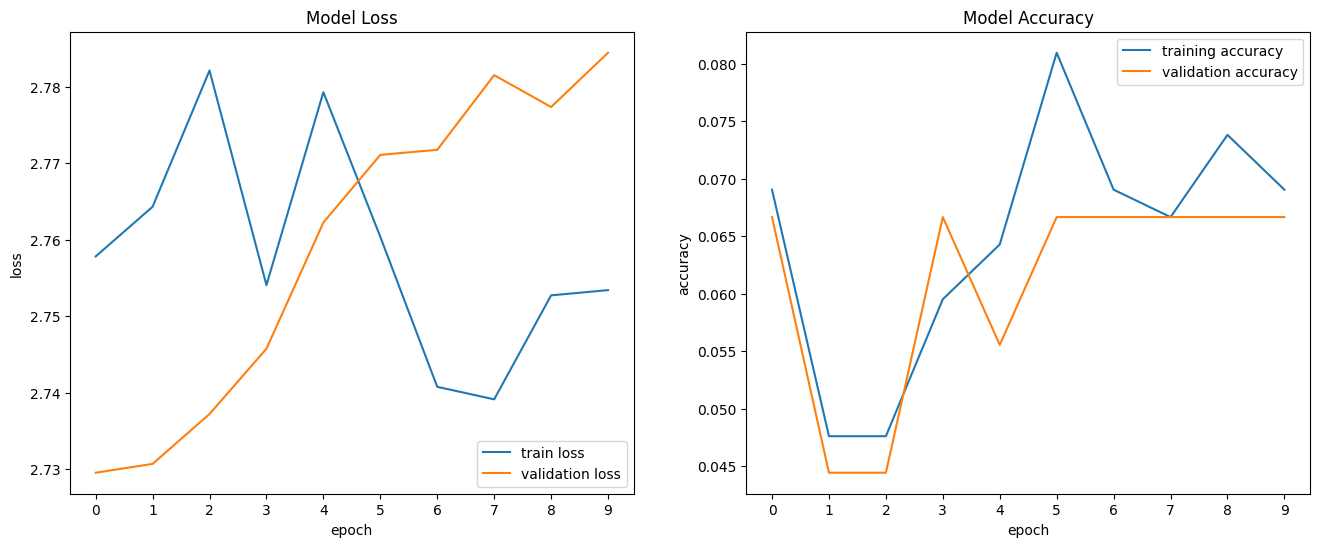

Epoch 10: Train Loss 2.7534 Acc 0.0690 | Val Loss 2.7844 Acc 0.0667
Training finished.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
print('Starting training...')

# Epoch Loop: It iterates through the specified number of training epochs.

for epoch in range(epochs):

    # For each epoch, all data in the dataset is processed.
    model.train() # Sets the model to training mode


    running_loss, correct, total = 0.0, 0, 0 # resetting loss/accuracy metrics

    #  Iterates through the `trainloader` to get mini-batches of data
    for x_batch, y_batch in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False):

        # copying data to the GPU (the `device`) if GPU is available
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)

        optimizer.zero_grad()           # setting up gradient to zero
        out = model(x_batch)            # Performs the forward pass
        loss = criterion(out, y_batch)  # calculates the loss
        loss.backward()                 # performs backpropagation in parallel on the batch
        optimizer.step()                # optimizer steps to update the model's weights

        # updating current training Loss and Accuracy on the mini-batch
        running_loss += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_acc = correct / total
    print(f'train_loss: {train_loss}; train_acc: {train_acc}')

    # Computing Validation Loss and Accuracy

    model.eval() # switching model to eval mode, disabling dropout/batchnorm/other custom modules
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad(): # we disable gradient computation to save some memory
        for x_batch, y_batch in tqdm(valloader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_running_loss += loss.item() * x_batch.size(0)
            preds = out.argmax(1)
            val_total += y_batch.size(0)
            val_correct += (preds == y_batch).sum().item()
    val_loss = val_running_loss / len(valloader.dataset)
    val_acc = val_correct / val_total

    # Record training loss and accuracy
    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc); val_acc_hist.append(val_acc)

    # At the end of the epoch, plot loss and accuracy for training/validation
    plotter.update(train_loss, train_acc, val_loss, val_acc)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}')

print('Training finished.')

As we see, even with serveral layers, the model's accurancy is still so poor. We need to convert the audio signals into spectrograms.



## Data Preprocessing and Feature Engineering
*   **Spectrograms:** Convert audio signals into spectrograms (time-frequency representations). These can be treated as images and processed using Convolutional Neural Networks (CNNs) designed for 2D data.

*   **Mel-Scale Frequency Cepstral Coefficients (MFCCs):** Instead of using raw audio waveforms, consider extracting more informative features like MFCCs. The human ear perceives frequencies on a non-linear scale (mel scale). MFCCs capture the spectral envelope of the sound, which is more relevant for human perception and often leads to better performance in audio tasks.


In [60]:
# Load improved 2D models and dataset
import importlib
import models
import audio_dataset

# Reload model2D
importlib.reload(models)
importlib.reload(audio_dataset)

from models import AudioClassifier
from audio_dataset import LoadAudio

print("✅ models2D and audio_dataset2D loaded!")

✅ models2D and audio_dataset2D loaded!


# Unit Test of Dataset and Model

In [61]:
# Immutable dataset args for evaluation
data_root = "/home/TCD/Lab-06/dataset/small_set_complete/"
meta_filename = "meta.txt"
audio_subdir = "audio"

# 1) Dataset tests
ds_ok, dataset2D, loader2D = test_dataset(
    LoadAudioClass=LoadAudio,
    root_dir=data_root,
    meta_filename=meta_filename,
    audio_subdir=audio_subdir,
    torch=torch,
    DataLoader=DataLoader,
    batch_size=1
)

# 2) Model summary & param budget
num_classes = getattr(dataset, "num_classes", 15)
model2D = AudioClassifier(num_classes=num_classes).to(device)
ms_ok = print_model_summary(model2D, summary, feature_example_shape=(1, 128, 431), max_params=5_000_000)

# 3) Model forward tests
mf_ok = test_model_forward(model2D, loader2D, torch, device=device, num_classes=num_classes)

print("\n=== Overall ===")
print("ALL TESTS PASSED ✅" if (ds_ok and ms_ok and mf_ok) else "SOME TESTS FAILED ❌")


=== Dataset Tester ===
Dataset instantiation: OK
Number of samples: 600
Possible classes (15): ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']
Class order matches reference list: OK

Iterating 5 minibatches (feature shapes):
  Batch 1:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 2:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 3:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 4:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)
  Batch 5:
    Item 1 shape: (1, 1, 128, 431)
    Item 2 shape: (1,)

Dataset tests: PASSED ✅

=== Model Summary ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 431]             320
       BatchNorm2d-2         [-1, 32, 128, 431]         

In [62]:
print(f"✅ Dataset loaded:")
print(f"   Tổng samples: {len(dataset2D)}")
print(f"   Số classes: {dataset2D.num_classes}")
print(f"   Classes: {dataset2D.class_names}")

✅ Dataset loaded:
   Tổng samples: 600
   Số classes: 15
   Classes: ['beach', 'bus', 'cafe/restaurant', 'car', 'city_center', 'forest_path', 'grocery_store', 'home', 'library', 'metro_station', 'office', 'park', 'residential_area', 'train', 'tram']


# Split data for training and testing

In [63]:
# Dataset cho training (no augmentation)
dataset_train_2d = LoadAudio(data_root, meta_filename, audio_subdir, training_flag=True)

# Dataset cho validation/test (augmentation)
dataset_eval_2d = LoadAudio(data_root, meta_filename, audio_subdir, training_flag=False)

In [64]:
total_size = len(dataset_train_2d)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

np.random.seed(42)  # For reproducibility
indices = np.random.permutation(total_size)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

trainset_2d = Subset(dataset_train_2d, train_indices.tolist())
valset_2d = Subset(dataset_eval_2d, val_indices.tolist())
testset_2d = Subset(dataset_eval_2d, test_indices.tolist())

print(f"   Training: {len(trainset_2d)} samples (augmentation)")
print(f"   Validation: {len(valset_2d)} samples (no augmentation)")
print(f"   Test: {len(testset_2d)} samples (no augmentation)")

   Training: 420 samples (augmentation)
   Validation: 90 samples (no augmentation)
   Test: 90 samples (no augmentation)


# Load models from models2D.py

In [65]:
import models
from models import AudioClassifier

In [66]:
model_2d = AudioClassifier(num_classes=dataset_train.num_classes).to(device)

# Kiểm tra số parameters
params_2d = sum(p.numel() for p in model_2d.parameters() if p.requires_grad)
print(f"   Parameters: {params_2d:,}")

# Hiển thị model architecture
from torchsummary import summary
summary(model_2d, (1, 128, 431))  # Input: Mel-Spectrogram shape

   Parameters: 1,915,503
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 431]             320
       BatchNorm2d-2         [-1, 32, 128, 431]              64
              ReLU-3         [-1, 32, 128, 431]               0
            Conv2d-4         [-1, 32, 128, 431]           9,248
       BatchNorm2d-5         [-1, 32, 128, 431]              64
              ReLU-6         [-1, 32, 128, 431]               0
         MaxPool2d-7          [-1, 32, 64, 215]               0
          VGGBlock-8          [-1, 32, 64, 215]               0
            Conv2d-9          [-1, 64, 64, 215]          18,496
      BatchNorm2d-10          [-1, 64, 64, 215]             128
             ReLU-11          [-1, 64, 64, 215]               0
           Conv2d-12          [-1, 64, 64, 215]          36,928
      BatchNorm2d-13          [-1, 64, 64, 215]             128
             R

# Optimiser and Dataloader Hyperparameter Setup

Here we define the dataloaders which handle the dataset, and the training optimiser.

Their hyperparameters include (but are not limited to):


*   Number of training epochs
*   Batch size
* Learning rate (step size)
* Optimiser momentum
* Dataset shuffling


In [67]:
epochs_2d = 40            # shorter for notebook demo - increase for training
batch_size_2d = 32        # play with this
learning_rate_2d = 0.0001 # play with this
momentum_2d = 0.9         # play with this
weight_decay_2d = 1e-4

criterion_2d = nn.CrossEntropyLoss()

# play with this
# Optimizer: Adam
optimizer_2d = torch.optim.Adam(
    model_2d.parameters(),
    lr=learning_rate_2d,
    weight_decay=weight_decay_2d,
    betas=(0.9, 0.999),
    eps=1e-8
)


# Learning Rate Scheduler:
scheduler_2d = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_2d,
    mode='max',           # Maximize validation accuracy
    factor=0.5,           # Diminue LR 50%
    patience=8,           # wait 8 epochs
    min_lr=1e-6
)

In [68]:
# Clear GPU memory before creating new model
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory cleared")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU memory cleared
GPU: Tesla T4
Total Memory: 15.83 GB


In [69]:
# Tạo DataLoaders cho 2D model
trainloader_2d = DataLoader(
    trainset_2d,
    batch_size=batch_size_2d,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

valloader_2d = DataLoader(
    valset_2d,
    batch_size=batch_size_2d,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# Reset plotter cho 2D model
plotter_2d = PlotLogAccuracy()
train_loss_hist_2d, val_loss_hist_2d = [], []
train_acc_hist_2d, val_acc_hist_2d = [], []

print(f"✅ DataLoaders created (batch_size={batch_size_2d})")

✅ DataLoaders created (batch_size=32)


In [70]:
# Clear GPU memory before creating new model
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory cleared")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU memory cleared
GPU: Tesla T4
Total Memory: 15.83 GB


Call your dataset, optimizers, scheduelers, implement training and validation dataloaders. Write your training loop.


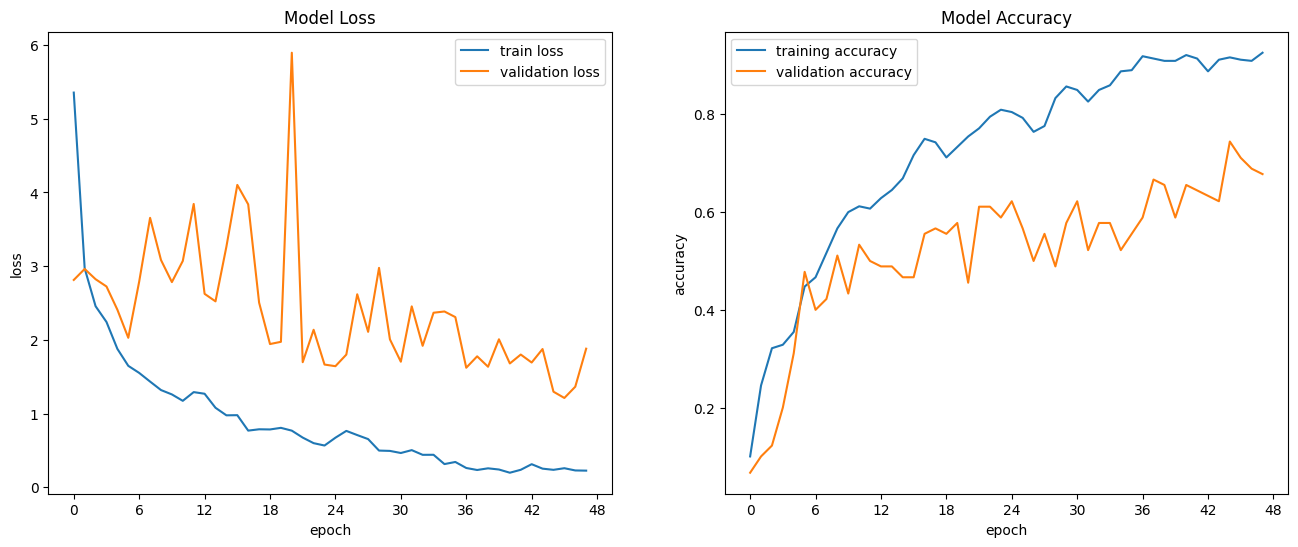

Epoch 40/40: Train 92.62% Loss 0.2263 | Val 67.78% Loss 1.8806 | Gap +24.84% OVERFIT | LR 0.000050 
Training finished!
Best validation accuracy: 0.7444 (74.44%)
Best validation loss: 1.2972
Goal 70%: OK
Model is saved at: model.pth


In [73]:
best_val_acc_2d = 0.0
best_val_loss_2d = float('inf')
patience_counter = 0
early_stop_patience = 15  # Early stopping patience

for epoch in range(epochs_2d):

    # ==================== TRAINING PHASE ====================
    model_2d.train()
    running_loss, correct, total = 0.0, 0, 0

    for x_batch, y_batch in tqdm(trainloader_2d, desc=f'Epoch {epoch+1}/{epochs_2d} [Train]', leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)

        optimizer_2d.zero_grad()
        out = model_2d(x_batch)
        loss = criterion_2d(out, y_batch)
        loss.backward()

        # Gradient clipping để tránh exploding gradients
        torch.nn.utils.clip_grad_norm_(model_2d.parameters(), max_norm=1.0)

        optimizer_2d.step()

        running_loss += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_loss = running_loss / len(trainloader_2d.dataset)
    train_acc = correct / total

    # ==================== VALIDATION PHASE ====================
    model_2d.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for x_batch, y_batch in tqdm(valloader_2d, desc=f'Epoch {epoch+1}/{epochs_2d} [Val]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
            out = model_2d(x_batch)
            loss = criterion_2d(out, y_batch)
            val_running_loss += loss.item() * x_batch.size(0)
            preds = out.argmax(1)
            val_total += y_batch.size(0)
            val_correct += (preds == y_batch).sum().item()

    val_loss = val_running_loss / len(valloader_2d.dataset)
    val_acc = val_correct / val_total

    # Update learning rate scheduler based on validation accuracy
    scheduler_2d.step(val_acc)

    # Lưu model tốt nhất (dựa trên validation accuracy)
    if val_acc > best_val_acc_2d:
        best_val_acc_2d = val_acc
        best_val_loss_2d = val_loss
        # torch.save(model_2d.state_dict(), 'model.pth')

        torch.save(model_2d, os.path.join('/content/gdrive/MyDrive/4c16-labs/code/lab-06', 'model.pth'))
        patience_counter = 0
        improvement_marker = 'BEST!'
    else:
        patience_counter += 1
        improvement_marker = ''

    # Lưu history
    train_loss_hist_2d.append(train_loss)
    val_loss_hist_2d.append(val_loss)
    train_acc_hist_2d.append(train_acc)
    val_acc_hist_2d.append(val_acc)

    # Plot progress
    plotter_2d.update(train_loss, train_acc, val_loss, val_acc)

    # In kết quả với overfitting indicator
    lr = optimizer_2d.param_groups[0]['lr']
    overfit_gap = train_acc - val_acc
    overfit_status = 'OVERFIT' if overfit_gap > 0.15 else 'OK'

    print(f'Epoch {epoch+1:2d}/{epochs_2d}: '
          f'Train {train_acc*100:5.2f}% Loss {train_loss:.4f} | '
          f'Val {val_acc*100:5.2f}% Loss {val_loss:.4f} | '
          f'Gap {overfit_gap*100:+5.2f}% {overfit_status} | '
          f'LR {lr:.6f} {improvement_marker}')

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f'\nEarly stopping! No improve after {early_stop_patience} epochs')
        break

print(f'Training finished!')
print(f'Best validation accuracy: {best_val_acc_2d:.4f} ({best_val_acc_2d*100:.2f}%)')
print(f'Best validation loss: {best_val_loss_2d:.4f}')
print(f'Goal 70%: {"OK" if best_val_acc_2d >= 0.70 else "More"}')
print(f'Model is saved at: model.pth')

## Evaluate Model on Test Set

In [77]:
loaded = torch.load('model.pth', map_location=device, weights_only=False)
loaded.eval()

testloader_2d = DataLoader(
    testset_2d,
    batch_size=batch_size_2d,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

test_correct, test_total = 0, 0
test_running_loss = 0.0

with torch.no_grad():
    for x_batch, y_batch in tqdm(testloader_2d, desc='Testing'):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).view(-1)
        out = loaded(x_batch)
        loss = criterion_2d(out, y_batch)
        test_running_loss += loss.item() * x_batch.size(0)
        preds = out.argmax(1)
        test_total += y_batch.size(0)
        test_correct += (preds == y_batch).sum().item()

test_loss = test_running_loss / len(testloader_2d.dataset)
test_acc = test_correct / test_total

print('='*70)
print(f'   Test Loss: {test_loss:.4f}')
print(f'   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print('='*70)

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

   Test Loss: 2.0849
   Test Accuracy: 0.6556 (65.56%)
